In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [3]:
import torchvision
import torchvision.transforms as transforms

def load_data_cifar_10(batch_size, resize=None):
    """Download the CIFAR10 dataset and then load it into memory with data augmentation for the training set."""
    # Define transformations for the training set
    train_transforms = [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
    
    # # Add resize transformation if specified
    if resize:
        train_transforms.insert(0, torchvision.transforms.Resize(resize))
    
    # Transformations for the testing set do not include data augmentation (only normalization)
    test_transforms = [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
    
    # Apply the transformations
    train_trans = torchvision.transforms.Compose(train_transforms)
    test_trans = torchvision.transforms.Compose(test_transforms)
    
    # Load datasets
    cifar_train = torchvision.datasets.CIFAR10(root="data", train=True, transform=train_trans, download=True)
    cifar_test = torchvision.datasets.CIFAR10(root="data", train=False, transform=test_trans, download=True)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader


In [4]:
# Example usage:
batch_size = 128
train_iter, test_iter = load_data_cifar_10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 128 images per batch. Each image is represented by a 3 x 32 x 32 tensor (number of channels x height x width). The images are RGB, so there is a 3 channel.
print(y.size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
  def __init__(self, in_channels, out_channels, num_conv_layers, dropout_rate):
    super(IntermediateBlock, self).__init__()

    self.conv_layers = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        ) for i in range(num_conv_layers)
    ]
)
    self.linear = nn.Linear(in_channels, num_conv_layers)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
      
    m = torch.mean(x, dim=[2,3])
    a = self.linear(m)
    a = F.softmax(a, dim=1)

    conv_output = [conv(x) for conv in self.conv_layers]
    stacked_conv_output = torch.stack(conv_output, dim=1)
    a_reshaped = a.view(a.size(0),a.size(1),1,1,1)
    x_prime = torch.sum(stacked_conv_output * a_reshaped, dim=1)

    return x_prime 




In [7]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, second_hidden_channels, num_classes, dropout_rate):
        super(OutputBlock, self).__init__()

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, second_hidden_channels)
        self.linear3 = nn.Linear(second_hidden_channels, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        m = torch.mean(x, dim=[2,3])

        out = self.linear1(m)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear3(out)
        return out


In [8]:
class CIFAR10Net(nn.Module):
    def __init__(self, initial_block_config, intermediate_blocks_configs, output_block_config):
        super(CIFAR10Net, self).__init__()
        self.initial_block = IntermediateBlock(**initial_block_config)

        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(**config) for config in intermediate_blocks_configs
        ])

        self.output_block = OutputBlock(**output_block_config)
    def forward(self, x):
        out = self.initial_block(x)
        for layer in self.intermediate_blocks:
            out = layer(out)
        out = self.output_block(out)
        return out

In [9]:
def init_weights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)

initial_block_config = {
    'in_channels': 3,
    'out_channels': 32,
    'num_conv_layers': 1,
    'dropout_rate': 0.2
}

intermediate_blocks_configs = [
    {'in_channels': 32, 'out_channels': 64, 'num_conv_layers': 2, 'dropout_rate': 0.2},
    {'in_channels': 64, 'out_channels': 128, 'num_conv_layers': 3, 'dropout_rate': 0.3},
    {'in_channels': 128, 'out_channels': 128, 'num_conv_layers': 4, 'dropout_rate': 0.4},
    {'in_channels': 128, 'out_channels': 128, 'num_conv_layers': 4, 'dropout_rate': 0.4}
]

output_block_config = {
    'in_channels': 128,  
    'hidden_channels': 64,
    'second_hidden_channels': 32,  
    'num_classes': 10,
    'dropout_rate': 0.2
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CIFAR10Net(
    initial_block_config,
    intermediate_blocks_configs,
    output_block_config
).to(device)

model.apply(init_weights)

CIFAR10Net(
  (initial_block): IntermediateBlock(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (linear): Linear(in_features=3, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (intermediate_blocks): ModuleList(
    (0): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (linear): Linear(in_features=32, out_features=2, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): IntermediateBlock(

In [10]:
loss = torch.nn.CrossEntropyLoss()

In [11]:
lr = 0.002
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

In [12]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


In [13]:
def evaluate_metric(model, data_iter, metric, device):
    """Compute the average `metric` of the model on a dataset, ensuring all tensors are on the same device."""
    c = 0.
    n = 0.
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)  # Move data to the correct device
            logits = model(X)
            c += metric(logits, y)
            n += len(y)

    return c / n

In [14]:
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct, device)}. Testing accuracy: {evaluate_metric(model, test_iter, correct, device)}.')

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training accuracy: 0.09989999979734421. Testing accuracy: 0.09510000050067902.



Epoch 1/100.
Training accuracy: 0.39093998074531555. Testing accuracy: 0.3734000027179718. Duration: 153.252s.

Epoch 2/100.
Training accuracy: 0.4525599777698517. Testing accuracy: 0.4316999912261963. Duration: 128.032s.

Epoch 3/100.
Training accuracy: 0.5201599597930908. Testing accuracy: 0.5174999833106995. Duration: 113.811s.

Epoch 4/100.
Training accuracy: 0.5777999758720398. Testing accuracy: 0.5681999921798706. Duration: 108.653s.

Epoch 5/100.
Training accuracy: 0.6006999611854553. Testing accuracy: 0.573199987411499. Duration: 113.646s.

Epoch 6/100.
Training accuracy: 0.6067799925804138. Testing accuracy: 0.6166999936103821. Duration: 109.001s.

Epoch 7/100.
Training accuracy: 0.6237199902534485. Testing accuracy: 0.6279999613761902. Duration: 113.631s.

Epoch 8/100.
Training accuracy: 0.636959969997406. Testing accuracy: 0.6369999647140503. Duration: 111.783s.

Epoch 9/100.
Training accuracy: 0.7009199857711792. Testing accuracy: 0.6780999898910522. Duration: 110.367s.

E

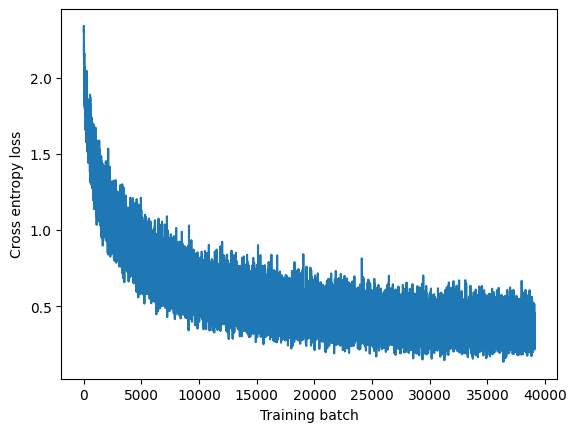

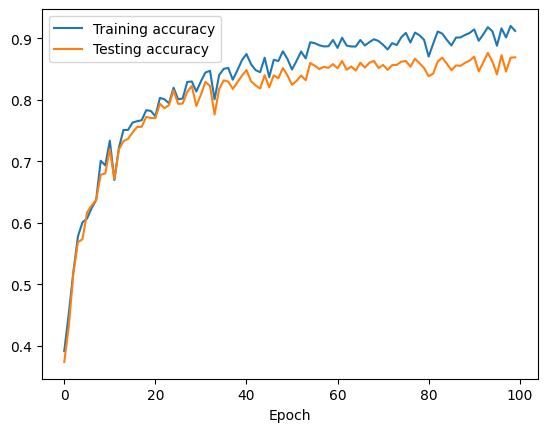

In [15]:
import time 

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 100
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters
        
        optimizer.step()  # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch


    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct, device))
        test_accs.append(evaluate_metric(model, test_iter, correct, device))
        
        end_time = time.perf_counter()
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

# Before plotting, convert tensors to CPU if necessary
train_accs_cpu = [acc.cpu() for acc in train_accs]
test_accs_cpu = [acc.cpu() for acc in test_accs]

plt.plot(train_accs_cpu, label='Training accuracy')
plt.plot(test_accs_cpu, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()
